In [2]:
import config_readwrite as crw
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import seaborn as sns

# files

In [3]:
cfn = os.path.join(os.path.dirname(os.getcwd()), "config.ini")
config, cfn = crw.read(cfn)

In [4]:
strategies = {"first_n_last": [True, True], 
             "last_only": [False, True], 
             "everything":[False, False],
             #"iterative":[] # TBD
              #"multioutput":[]
             }

In [5]:
STRATEGY = "first_n_last"
ADD_LAYERS, FREEZE = strategies[STRATEGY]
PREFIX = "AGARWAL.seqs"
section = "agarwal_mpra"

TRUTH = config[section]["MPRA_ACTIVITY"] # US activity in HepG2

PRED_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/"
PRED = os.path.join(PRED_PATH, f"inference.{PREFIX}.{STRATEGY}.retrain.tsv")  # legnet predictions
INFO = config[section]["MPRA_INFO"]

In [6]:
CL = 'hepg2'
SIZE = "0.9"
TRAIN = config[section][f"training.{CL}.{SIZE}"] # training data
TEST = config[section][f"test.{CL}.{SIZE}"] # training data


SEQ_SIZE = 200
config[section]["SEQ_SIZE"] = str(SEQ_SIZE)

In [7]:
section = f"LegNet.agarwal.{STRATEGY}"
crw.check(config, section)

# legnet 
infile = os.path.split(TRAIN)[1]
model_dir = os.path.join(PRED_PATH, "re" + ".".join(infile.split(".")[:-1]) + "." + STRATEGY)
MODEL = os.path.join(model_dir, "model_9.pth")
INFERENCE = os.path.join(PRED_PATH, f"inference.test.{CL.upper()}.{SEQ_SIZE}.{STRATEGY}.tsv")

config[section]["path"] = PRED_PATH
config[section]["model_dir"]=model_dir
config[section]["model_10"]= MODEL
config[section]["inference"]= INFERENCE

crw.write(config, cfn)

# run legnet

In [8]:
def parseTrainArgs(train_input, seqsize, new_layers, freeze, model_dir):

    args = [
        "--train_valid_path", train_input,
        "--foldify",
        "--delimiter tab",
        "--seed 42",
        "--train_batch_size 1024",
        "--train_workers 8",
        "--valid_batch_size 4098",
        "--valid_workers 8",
        "--epoch_num 5",
        "--batch_per_epoch 10",
        "--weights uniform",
        "--seqsize", str(seqsize),
        "--temp .TEMPDIR",
        "--use_single_channel",
        "--singleton_definition integer",
        "--gpu 0",
        "--model_dir",model_dir, 
        "--ks 7",
        "--blocks 256 128 128 64 64 64 64",
        "--resize_factor 4",
        "--se_reduction 4",
        "--shift 0.5",
        "--scale 0.5",
        "--loss kl",
        "--final_ch 18",
        "--optimizer adamw",
        "--model /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/model_300.pth"]
    if new_layers is True:
        args.append("--tl_layers")
    if freeze is True:
        args.append("--freeze_layers")

    return " ".join(args)

In [17]:
def parseTestArgs(test_input, test_output, seqsize, model, new_layers):
    args = [
        "--target",  test_input,
        "--output", test_output,
        "--seed 42",
        "--valid_batch_size 124",
        "--valid_workers 8",
        "--seqsize", str(seqsize),
        "--temp .TEMPDIR",
        "--use_single_channel",
        "--singleton_definition integer",
        "--gpu 0", "--ks 7",
        "--blocks 256 128 128 64 64 64 64",
        " --resize_factor 4",
        "--se_reduction 4",
        "--final_ch 18",
        "--delimiter tab",
        "--output_format tsv",
        "--model",  model
    ]
    if new_layers is True:
        args.append("--tl_layers")
    return " ".join(args)

In [18]:
def launchLegNetTrain(train_input, seqsize, first, last, strategy):
    """ predict 18 bins using input sequence, write to output file, specify sequence size"""

    PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/bin/"
    TRAIN_LEGNET_SH = os.path.join(PATH, "train_transfer_lastlayer.sh")

    OUTPUT_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/"

    # str split to make output file a copy of the input file.
    infile = os.path.split(train_input)[1]
    model_dir = os.path.join(
        OUTPUT_PATH, "re" + ".".join(infile.split(".")[:-1]) + "." + strategy)

    # legnet training arguments
    args = parseTrainArgs(train_input, seqsize, first,
                          last, model_dir)  # get arguments for LegNet
   
    cmd = " ".join(["qsub -q gpu.q",
                   TRAIN_LEGNET_SH               
                    ])
    
    # add arguments to command
    cmd = cmd + " " + args
    
    print(cmd)
    
    #os.system(cmd)
    if os.path.exists(model_dir) is False:
        os.system(cmd)
    else:
        print("trained already?")

    return model_dir

# Retrain?

In [15]:
model_dir = launchLegNetTrain(TRAIN, SEQ_SIZE, ADD_LAYERS, FREEZE, STRATEGY)

qsub -q gpu.q /wynton/home/ahituv/fongsl/EMF/US/ml_emf/bin/train_transfer_lastlayer.sh --train_valid_path /wynton/home/ahituv/fongsl/EMF/US/data/training.HepG2.0.9.txt --foldify --delimiter tab --seed 42 --train_batch_size 1024 --train_workers 8 --valid_batch_size 4098 --valid_workers 8 --epoch_num 10 --batch_per_epoch 500 --weights uniform --seqsize 200 --temp .TEMPDIR --use_single_channel --singleton_definition integer --gpu 0 --model_dir /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/retraining.HepG2.0.9.first_n_last --ks 7 --blocks 256 128 128 64 64 64 64 --resize_factor 4 --se_reduction 4 --shift 0.5 --scale 0.5 --loss kl --final_ch 18 --optimizer adamw --model /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/model_300.pth --tl_layers --freeze_layers
trained already?


# test

In [23]:
def launchLegNetInference(test_input, seqsize, model, cl, strategy, add_layers):
    """ predict 18 bins using input sequence, write to output file, specify sequence size"""

    PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/bin/"
    LEGNET_SH = os.path.join(PATH, "legnet_inference.sh")

    OUTPUT_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/"

    # str split to make output file a copy of the input file.
    infile = os.path.split(test_input)[1]
    test_output = os.path.join(OUTPUT_PATH, f"inference.test.{cl.upper()}.{seqsize}.{strategy}.tsv")

    cmd = " ".join(["qsub -q gpu.q",
                   LEGNET_SH
                   ])
    args = parseTestArgs(test_input, test_output, seqsize, model, add_layers)
    
    
    cmd = cmd + " " + args
    
    print(cmd)
    #os.system(cmd)
    if os.path.exists(test_output) is False:
        print("running...")
        os.system(cmd)
    else:
        print("skipping...", test_output)

## Inference 

In [30]:
launchLegNetInference(TEST, SEQ_SIZE, MODEL, CL, STRATEGY, ADD_LAYERS)

qsub -q gpu.q /wynton/home/ahituv/fongsl/EMF/US/ml_emf/bin/legnet_inference.sh --target /wynton/home/ahituv/fongsl/EMF/US/data/test.HepG2.0.9.txt --output /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/inference.test.HEPG2.200.first_n_last.tsv --seed 42 --valid_batch_size 124 --valid_workers 8 --seqsize 200 --temp .TEMPDIR --use_single_channel --singleton_definition integer --gpu 0 --ks 7 --blocks 256 128 128 64 64 64 64  --resize_factor 4 --se_reduction 4 --final_ch 18 --delimiter tab --output_format tsv --model /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/retraining.HepG2.0.9.first_n_last/model_9.pth --tl_layers
running...


## plot training scores

In [31]:
scores = glob.glob(os.path.join(model_dir, "scores*"))
score_dict={}
for score in scores:
    with open(score, "r") as reader:
        line=json.load(reader)
        score_cols = list(line)
        pearson = line[list(line)[0]]
        mse = line[list(line)[1]]
        spearman = line[list(line)[2]]
        score_dict[os.path.split(score)[1]] = [pearson, mse, spearman, os.path.split(score)[1]]
score_cols.append("iter")  # add iter number column
scoredf = pd.DataFrame(score_dict.values())  # name dataframe
scoredf.columns = score_cols  # plot names

scoredf.head()

,train_pearson,train_mse,train_spearman,iter
0,0.065847,32.359486,0.071242,scores_1.json
1,0.124669,26.612593,0.123511,scores_2.json
2,0.178551,26.328697,0.176173,scores_3.json
3,0.197536,26.080816,0.194035,scores_4.json
4,0.207991,25.897101,0.204564,scores_5.json


[Text(0.5, 0, 'epoch'),
 Text(0, 0.5, 'corr'),
 Text(0.5, 1.0, 'first_n_last-hepg2')]

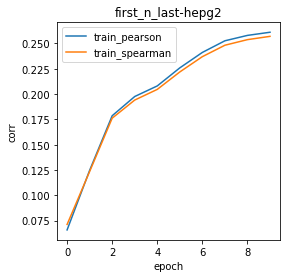

In [32]:
fig, ax = plt.subplots(figsize =(4,4))
x = scoredf.index
y = 'train_pearson'
sns.lineplot(x=x, y=y, data= scoredf, label=y)

y = 'train_spearman'
sns.lineplot(x=x, y=y, data= scoredf, label=y)
ax.set(xlabel = 'epoch', ylabel="corr", title=STRATEGY + "-" + CL)

# Truth v. Pred

## data loading

### load MPRA activity truth

In [33]:
# load truth

truth = pd.read_csv(TRUTH) # load data

truth.head()

,name,HepG2 [log2(rna/dna)],K562 [log2(rna/dna)],WTC11 [log2(rna/dna)]
0,WTC11_seq9998_F,-1.018,-1.018,-1.254
1,WTC11_seq9987_F,0.320,-0.439,-1.505
2,WTC11_seq998_F,0.003,-0.217,-0.462
3,WTC11_seq9970_F,-0.794,-1.026,-1.414
4,WTC11_seq9967_F,-0.485,-0.592,-1.346


### load LegNet predictions

In [34]:
INFERENCE

'/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/inference.test.HEPG2.200.first_n_last.tsv'

In [35]:
# load predictions
pred = pd.read_csv(INFERENCE, sep='\t', header=None, names=["seq", "pred"])
pred.head()

,seq,pred
0,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,10.421378
1,TTCATTCTATTTCTCCAGCGAGAGTGCAGAGGTTTGGACCCCCGTT...,9.072244
2,GTTTAGAGAATGCCACTCAGAGATAGGAATCAGGACAGGAAGTGGA...,8.038956
3,CATCTTGTACTTTGCCCTCATAGAATTTGCCTTGGTTCATACTATA...,6.456797
4,AGCTCAGTTTCTCTGGTCCCAGCTGTGCAAACAAATACCTGGGTCA...,7.757834


## merge seq_id, pred, bed, truth

In [36]:
# merge truth and prediction
merged = pd.read_csv(INFO, sep='\t')
merged=pd.merge(merged, pred)
merged.head()

,seq.id,seq,name,HepG2 [log2(rna/dna)],K562 [log2(rna/dna)],WTC11 [log2(rna/dna)],WTC11_q,HepG2_q,K562_q,pred
0,chr1:19461350-19461550,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,WTC11_seq1000_F,0.633,0.080,-0.387,12.0,15.0,12.0,10.421378
1,chr1:19640565-19640765,TTCATTCTATTTCTCCAGCGAGAGTGCAGAGGTTTGGACCCCCGTT...,WTC11_seq1004_F,0.006,-0.733,0.330,15.0,11.0,4.0,9.072244
2,chr10:91672425-91672625,GTTTAGAGAATGCCACTCAGAGATAGGAATCAGGACAGGAAGTGGA...,WTC11_seq10070_F,0.455,0.905,0.453,15.0,14.0,16.0,8.038956
3,chr10:91724691-91724891,CATCTTGTACTTTGCCCTCATAGAATTTGCCTTGGTTCATACTATA...,WTC11_seq10072_F,-0.577,-0.815,-1.211,5.0,6.0,3.0,6.456797
4,chr10:93280280-93280480,AGCTCAGTTTCTCTGGTCCCAGCTGTGCAAACAAATACCTGGGTCA...,WTC11_seq10115_F,-1.458,-1.132,-1.666,0.0,0.0,0.0,7.757834


In [37]:
truth.shape, pred.shape, merged.shape, 

((56981, 4), (5635, 2), (5635, 10))

### fill na w/ zeros

In [38]:
# fill na for pearson, spearman
test = merged.fillna(0)

# Performance predicting MPRA

## HepG2 MPRA

In [39]:
if CL == 'hepg2':
    CL_Q = f"HepG2 [log2(rna/dna)]"
    HUE = 'HepG2_q'
else:
    CL_Q = f"{CL.upper()} [log2(rna/dna)]"
    HUE = f"{CL}_q"
CL_Q, HUE

('HepG2 [log2(rna/dna)]', 'HepG2_q')

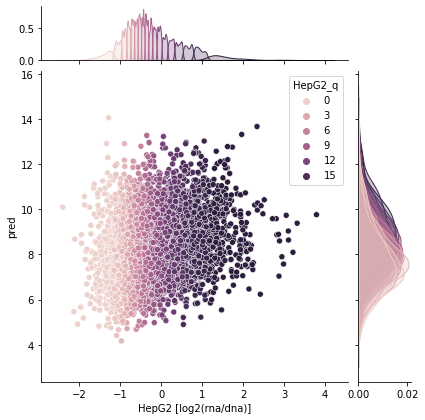

In [40]:
x = CL_Q
y = "pred"
hue = HUE
g = sns.jointplot(x=x, y=y, data=merged,
                  hue=hue,


                  marginal_ticks=True
                  )

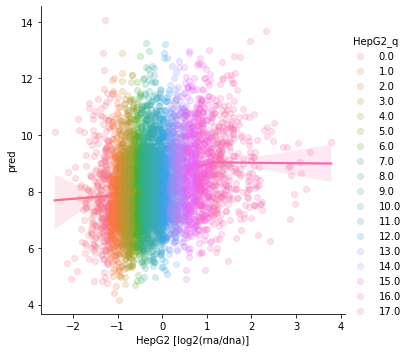

In [41]:
sns.lmplot(x=x, y=y, data=merged,
           hue=hue,
           scatter_kws={"alpha": 0.2}
           )
#g.set(ylabel="LegNet predicted bin")

In [42]:
# pearson, spearman
stats.pearsonr(test[x], test[y]), stats.spearmanr(test[x], test[y])

((0.27437145228185406, 7.170451956960499e-98),
 SpearmanrResult(correlation=0.28288869801147215, pvalue=3.5308562053079707e-104))

HepG2 BASELINE:
        
    ((0.12551376346319143, 1.414916369293078e-196),
     SpearmanrResult(correlation=0.15845689586256376, pvalue=0.0))
     
10 epochs, 100 batches 9% of data: 
        
    ((0.2290417883890271, 0.0),
     SpearmanrResult(correlation=0.22938714360487428, pvalue=0.0))
         
10 epochs, 500 batches, 90% of data, all unfrozen:
         
     ((0.357861834279381, 7.009401269666126e-170),
     SpearmanrResult(correlation=0.36200474250413345, pvalue=4.464356644359343e-174))
     
10 epochs, 500 batches, 90% of data, all frozen, new first and last layer:

    ((0.27437145228185406, 7.170451956960499e-98),
     SpearmanrResult(correlation=0.28288869801147215, pvalue=3.5308562053079707e-104))

## y true v. y pred for HepG2 bins

[(0.0, 18.0)]

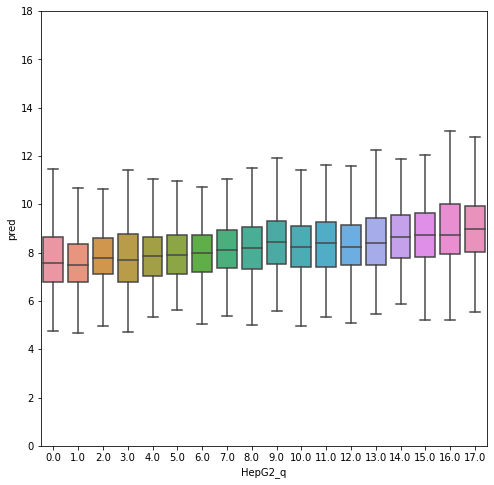

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(x="HepG2_q", y = "pred", data=merged, showfliers=False)
ax.set(ylim=(0,18))

## MSE

In [49]:
from sklearn.metrics import mean_squared_error

merged = merged.loc[~merged["WTC11_q"].isna()]
mean_squared_error(test["WTC11_q"].fillna(0), test["pred"])#.fillna(0))

25.553033781604647

## WTC11 MPRA

((0.25746670566631813, 5.4073275177193745e-86),
 SpearmanrResult(correlation=0.22985161396324044, pvalue=1.9167030328732505e-68))

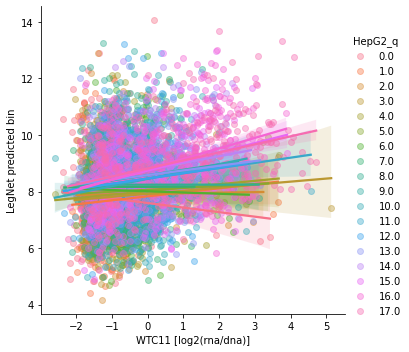

In [50]:
x="WTC11 [log2(rna/dna)]"
y="pred"
g = sns.lmplot(x=x, y=y, data=merged, 
           hue="HepG2_q", 
          scatter_kws={"alpha":0.4}, 
         )
g.set(ylabel="LegNet predicted bin")

# pearson, spearman
stats.pearsonr(merged[x], merged[y]), stats.spearmanr(merged[x], merged[y])

WTC11 - BASELINE


    ((0.316254248136727, 0.0),
     SpearmanrResult(correlation=0.32341219943458566, pvalue=0.0))
     
10 epochs, 100 batches WTC11 9% of data:
    
    ((0.5302539307550675, 0.0),
     SpearmanrResult(correlation=0.5467446744170327, pvalue=0.0))
10 epochs, 500 batches, 90% of WTC11 data, all unfrozen:

    ((0.7300249734946105, 0.0),
     SpearmanrResult(correlation=0.7720184604584711, pvalue=0.0))
     
10 epochs, 500 batches, 90% of HEPG2 data, first and last new layers, frozen:

    ((0.25746670566631813, 5.4073275177193745e-86),
     SpearmanrResult(correlation=0.22985161396324044, pvalue=1.9167030328732505e-68))

## k562 MPRA

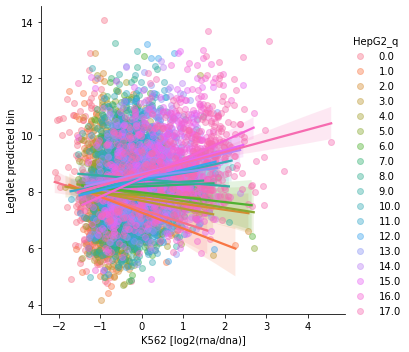

In [44]:
x="K562 [log2(rna/dna)]"
y="pred"
g = sns.lmplot(x=x, y=y, data=merged, 
          hue="HepG2_q", 
          scatter_kws={"alpha":0.4})
g.set(ylabel="LegNet predicted bin")

In [20]:
# pearson, spearman
stats.pearsonr(test[x], test[y]), stats.spearmanr(test[x], test[y])

((0.3169430568889067, 0.0),
 SpearmanrResult(correlation=0.2913339659378792, pvalue=0.0))

k562 BASELINE:
        
        ((0.18226562465561197, 0.0),
     SpearmanrResult(correlation=0.17494234006248102, pvalue=0.0))
 10 epochs, 10 batches:
 
     ((0.28345762569685845, 0.0),
     SpearmanrResult(correlation=0.26950949278353425, pvalue=0.0))
 10 epochs, 100 batches:
 
     ((0.3169430568889067, 0.0),
     SpearmanrResult(correlation=0.2913339659378792, pvalue=0.0))

# interpretations
Base line:
- WTC11 looks the best. Pearson's R= 0.32, Spearman = 0.32

- HepG2 is the worst. Pearson's R = 0.12, Spearman (robust) = 0.15

- k562 is intermediate. Pearson's R = 0.18, Spearman = 0.17

retraining: 

- improvements are greatest for WTC11, not for Hepg2, but dependent variable and training task is trying to predict WTC11, so I think the retraining is working.
- need to figure out:
    - how to optimize for other cell types. More output nodes. 
    - increase the number of training examples/training size of the dataset. 
    